# Enhanced Skin Cancer Detection Using Diffusion-Based Data Augmentation and Vision Transformers

# Mounting the Drive

# Installing Libraries

In [44]:
# %pip uninstall -y torch torchvision
# %pip install torch==2.5.0 torchvision==0.20.0
# %pip install evaluate

In [45]:
import pandas as pd
import os
import numpy as np
from PIL import Image
import cv2

import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, transforms
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from transformers import AutoImageProcessor, AutoModelForImageClassification, Trainer, TrainingArguments

# Data Preprocessing

### Import Training Data

In [46]:
def process_dataset(csv_file, image_dir, label_map):
    labels_df = pd.read_csv(csv_file, header=None, names=['image_id', 'label'])
    labels_df['label'] = labels_df['label'].map(label_map)
    labels_df['file_path'] = labels_df['image_id'].apply(lambda x: os.path.join(image_dir, f"{x}.jpg"))
    
    return labels_df

label_map_train = {'benign': 0, 'malignant': 1}
label_map_test = {0.0: 0, 1.0: 1}

train_csv_file = 'datasets/ISIC2016/ISBI2016_ISIC_Part3_Training_GroundTruth.csv'
train_image_dir = 'datasets/ISIC2016/ISBI2016_ISIC_Part1_Training_Data'

test_csv_file = 'datasets/ISIC2016/ISBI2016_ISIC_Part3_Test_GroundTruth.csv'
test_image_dir = 'datasets/ISIC2016/ISBI2016_ISIC_Part1_Test_Data'

train_labels_df = process_dataset(train_csv_file, train_image_dir, label_map_train)
test_labels_df = process_dataset(test_csv_file, test_image_dir, label_map_test)
validation_labels_df, test_labels_df = train_test_split(test_labels_df, test_size=0.5, random_state=42)

train_labels_df.head()


,image_id,label,file_path
0,ISIC_0000000,0,datasets/ISIC2016/ISBI2016_ISIC_Part1_Training...
1,ISIC_0000001,0,datasets/ISIC2016/ISBI2016_ISIC_Part1_Training...
2,ISIC_0000002,1,datasets/ISIC2016/ISBI2016_ISIC_Part1_Training...
3,ISIC_0000004,1,datasets/ISIC2016/ISBI2016_ISIC_Part1_Training...
4,ISIC_0000006,0,datasets/ISIC2016/ISBI2016_ISIC_Part1_Training...


### Characterize and Visualize Dataset

Dataset has 2 classes and 900 samples.
Class counts:
0    727
1    173
Name: label, dtype: int64


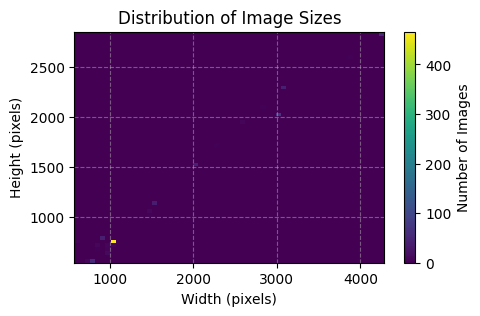

Dataset has 2 classes and 189 samples.
Class counts:
0    152
1     37
Name: label, dtype: int64


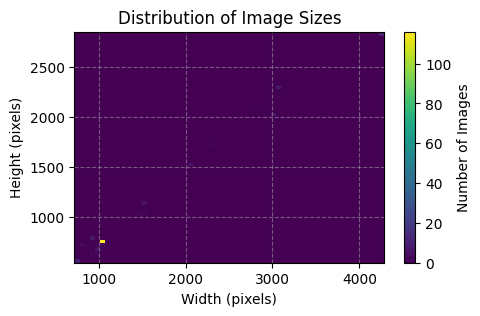

Dataset has 2 classes and 190 samples.
Class counts:
0    152
1     38
Name: label, dtype: int64


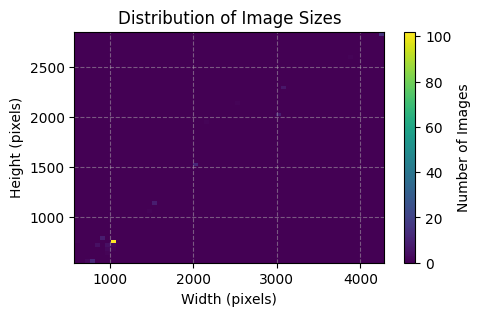

In [47]:
def characterize_dataset(labels_df):
        widths, heights = [], []
        class_counts = labels_df['label'].value_counts()
        
        for idx, row in labels_df.iterrows():
            image = Image.open(row['file_path'])
            widths.append(image.size[0])
            heights.append(image.size[1])
        
        print(f"Dataset has {len(class_counts)} classes and {len(labels_df)} samples.")
        print(f"Class counts:\n{class_counts}")
       
        plt.figure(figsize=(5, 3))
        plt.hist2d(widths, heights, bins=60, cmap='viridis')
        plt.colorbar(label='Number of Images')
        plt.title("Distribution of Image Sizes")
        plt.xlabel("Width (pixels)")
        plt.ylabel("Height (pixels)")
        plt.grid(True, linestyle='--', alpha=0.5)
        plt.show()

characterize_dataset(train_labels_df)
characterize_dataset(validation_labels_df)
characterize_dataset(test_labels_df)

In [48]:
class ISICDataset(Dataset):
    def __init__(self, labels_df, transform=None):
        self.labels_df = labels_df
        self.transform = transform

    def __len__(self):
        return len(self.labels_df)

    def __getitem__(self, idx):
        row = self.labels_df.iloc[idx]
        img_path = row['file_path']
        image = Image.open(img_path).convert("RGB")
        label = row['label']
        
        if self.transform:
            image = self.transform(image)
            
        return image, label
    
    
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    # transforms.Normalize(mean=mean, std=std)
])

train_dataset = ISICDataset(train_labels_df, transform=transform)
data_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)


### Plotting Samples


In [49]:
# def plot_samples(dataset, rows=2, cols=5):
#     fig, axes = plt.subplots(rows, cols, figsize=(cols*3, rows*3))
#     axes = axes.flatten()
#     for i in range(rows*cols):
#         img, label = dataset[i]
#         axes[i].imshow(img.permute(1, 2, 0))  # Convert from (C, H, W) to (H, W, C)
#         axes[i].set_title('Malignant' if label == 1 else 'Benign')
#         axes[i].axis('off')
#     plt.show()

# plot_samples(labels_df)

# Diffusion-Based Augmentation

### Define Training Configuration for Diffusion-based Augmentation

In [50]:
from dataclasses import dataclass

# TODO: change config
@dataclass
class TrainingConfig:
    image_size = 224
    train_batch_size = train_dataset.__len__()  # the batch size during training
    eval_batch_size = 16  # how many images to sample during evaluation
    num_epochs = 50
    gradient_accumulation_steps = 1
    learning_rate = 1e-4
    lr_warmup_steps = 500
    save_image_epochs = 10
    save_model_epochs = 30
    mixed_precision = "no"
    output_dir = "output"  # where to store the model
    seed = 0


config = TrainingConfig()

### Model: UNet2DModel

In [51]:
from diffusers import UNet2DModel

model = UNet2DModel(
    sample_size=config.image_size,  # the target image resolution
    in_channels=3,  # the number of input channels, 3 for RGB images
    out_channels=3,  # the number of output channels
    layers_per_block=2,  # how many ResNet layers to use per UNet block
    block_out_channels=(128, 128, 256, 256, 512, 512),  # the number of output channels for each UNet block
    down_block_types=(
        "DownBlock2D",  # a regular ResNet downsampling block
        "DownBlock2D",
        "DownBlock2D",
        "DownBlock2D",
        "AttnDownBlock2D",  # a ResNet downsampling block with spatial self-attention
        "DownBlock2D",
    ),
    up_block_types=(
        "UpBlock2D",  # a regular ResNet upsampling block
        "AttnUpBlock2D",  # a ResNet upsampling block with spatial self-attention
        "UpBlock2D",
        "UpBlock2D",
        "UpBlock2D",
        "UpBlock2D",
    ),
)

In [52]:
# Santiy Check: Sample image size

sample_image = train_dataset[0][0].unsqueeze(0)
print("Input shape:", sample_image.shape)

print("Output shape:", model(sample_image, timestep=0).sample.shape)

Input shape: torch.Size([1, 3, 224, 224])
Output shape: torch.Size([1, 3, 224, 224])


### Noise Scheduler

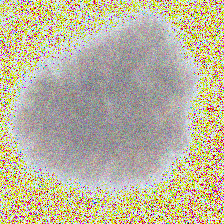

In [53]:
from diffusers import DDPMScheduler

noise_scheduler = DDPMScheduler(num_train_timesteps=1000)
noise = torch.randn(sample_image.shape)
timesteps = torch.LongTensor([50])
noisy_image = noise_scheduler.add_noise(sample_image, noise, timesteps)

Image.fromarray(((noisy_image.permute(0, 2, 3, 1) + 1.0) * 127.5).type(torch.uint8).numpy()[0])

In [54]:
# Loss step

import torch.nn.functional as F

noise_pred = model(noisy_image, timesteps).sample
loss = F.mse_loss(noise_pred, noise)

print("Loss:", loss.item())

Loss: 1.0551038980484009


### Training the Diffusion Model

In [55]:
from diffusers.optimization import get_cosine_schedule_with_warmup

optimizer = torch.optim.AdamW(model.parameters(), lr=config.learning_rate)
lr_scheduler = get_cosine_schedule_with_warmup(
    optimizer=optimizer,
    num_warmup_steps=config.lr_warmup_steps,
    num_training_steps=(train_dataset.__len__() * config.num_epochs),
)

In [56]:
from diffusers.utils import make_image_grid
import os

def evaluate(config, epoch, pipeline):
    # Sample some images from random noise (this is the backward diffusion process).
    # The default pipeline output type is `List[PIL.Image]`
    images = pipeline(
        batch_size=config.eval_batch_size,
        generator=torch.Generator(device='cpu').manual_seed(config.seed), # Use a separate torch generator to avoid rewinding the random state of the main training loop
    ).images

    # Make a grid out of the images
    image_grid = make_image_grid(images, rows=4, cols=4)

    # Save the images
    test_dir = os.path.join(config.output_dir, "samples")
    os.makedirs(test_dir, exist_ok=True)
    image_grid.save(f"{test_dir}/{epoch:04d}.png")

In [57]:
from accelerate import Accelerator
from tqdm.auto import tqdm
from pathlib import Path
import os
import torch
import torch.nn.functional as F

def train_loop(config, model, noise_scheduler, optimizer, train_dataloader, lr_scheduler):
    # Initialize accelerator and tensorboard logging
    accelerator = Accelerator(
        mixed_precision="no",
        cpu=True,
        gradient_accumulation_steps=config.gradient_accumulation_steps,
        log_with="tensorboard",
        project_dir=os.path.join(config.output_dir, "logs"),
    )
    
    # Create output directory if it doesn't exist
    if accelerator.is_main_process:
        if config.output_dir is not None:
            os.makedirs(config.output_dir, exist_ok=True)
    
    # Prepare everything (accelerator prepares models and data loaders for distributed training)
    model, optimizer, train_dataloader, lr_scheduler = accelerator.prepare(
        model, optimizer, train_dataloader, lr_scheduler
    )

    global_step = 0

    # Training loop
    for epoch in range(config.num_epochs):
        progress_bar = tqdm(total=len(train_dataloader), disable=not accelerator.is_local_main_process)
        progress_bar.set_description(f"Epoch {epoch}")

        for step, batch in enumerate(train_dataloader):
            clean_images = batch[0]
            # Sample noise to add to the images
            noise = torch.randn(clean_images.shape, device=clean_images.device)
            bs = clean_images.shape[0]

            # Sample a random timestep for each image
            timesteps = torch.randint(
                0, noise_scheduler.config.num_train_timesteps, (bs,), device=clean_images.device,
                dtype=torch.int64
            )

            # Add noise to the clean images according to the noise magnitude at each timestep
            # (this is the forward diffusion process)
            noisy_images = noise_scheduler.add_noise(clean_images, noise, timesteps)

            with accelerator.accumulate(model):
                # Predict the noise residual
                noise_pred = model(noisy_images, timesteps, return_dict=False)[0]
                loss = F.mse_loss(noise_pred, noise)
                accelerator.backward(loss)

                if accelerator.sync_gradients:
                    accelerator.clip_grad_norm_(model.parameters(), 1.0)
                optimizer.step()
                lr_scheduler.step()
                optimizer.zero_grad()

            progress_bar.update(1)
            logs = {"loss": loss.detach().item(), "lr": lr_scheduler.get_last_lr()[0], "step": global_step}
            progress_bar.set_postfix(**logs)
            accelerator.log(logs, step=global_step)
            global_step += 1

        # After each epoch, optionally sample demo images and save the model
        if accelerator.is_main_process:
            pipeline = DDPMPipeline(unet=accelerator.unwrap_model(model), scheduler=noise_scheduler)

            # Save images at intervals
            if (epoch + 1) % config.save_image_epochs == 0 or epoch == config.num_epochs - 1:
                evaluate(config, epoch, pipeline)

            # Save model locally (skip Hugging Face Hub integration)
            if (epoch + 1) % config.save_model_epochs == 0 or epoch == config.num_epochs - 1:
                pipeline.save_pretrained(config.output_dir)

In [58]:
from accelerate import notebook_launcher

args = (config, model, noise_scheduler, optimizer, train_dataset, lr_scheduler)

# notebook_launcher(train_loop, args, num_processes=1)

# Classification using Vision Transformers

### Defining the Model

In [59]:
class ISICDatasetTransform(Dataset):
    def __init__(self, labels_df, processor=None):
        self.labels_df = labels_df
        self.processor = processor

    def __len__(self):
        return len(self.labels_df)

    def __getitem__(self, idx):
        row = self.labels_df.iloc[idx]
        image = Image.open(row['file_path']).convert("RGB")
        label = row['label']
            
        inputs = self.processor(images=image, return_tensors="pt")
        # print(f"Shape of pixel_values: {inputs['pixel_values'].shape}")
        inputs['labels'] = torch.tensor(label)
        
        return inputs

### 

In [60]:
def load_model_and_processor(model_name):
    processor = AutoImageProcessor.from_pretrained(model_name)
    model = AutoModelForImageClassification.from_pretrained(
        model_name,
        num_labels=2,
        ignore_mismatched_sizes = True
    )
    for name,p in model.named_parameters():
        if not name.startswith('classifier'):
            p.requires_grad = False

    num_params = sum([p.numel() for p in model.parameters()])
    trainable_params = sum([p.numel() for p in model.parameters() if p.requires_grad])

    print(f"{num_params = :,} | {trainable_params = :,}")

    return model, processor

def collate_fn(batch):
    pixel_values = torch.stack([x['pixel_values'].squeeze(0) for x in batch])
    labels = torch.tensor([x['labels'] for x in batch])
    
    # # Check the shape of the batch
    # print(f"Shape of pixel_values batch: {pixel_values.shape}")
    # print(f"Shape of labels batch: {labels.shape}")
    
    return {
        'pixel_values': pixel_values,
        'labels': labels
    }

import evaluate
accuracy = evaluate.load('accuracy')
def compute_metrics(eval_preds):
    logits, labels = eval_preds
    predictions = np.argmax(logits,axis=1)
    score = accuracy.compute(predictions=predictions, references=labels)
    return score


In [61]:
# Evaluate several models in sequence
model_names = ["google/vit-base-patch16-224"]
results = {}

for model_name in model_names:
    # Load model and processor
    model, processor = load_model_and_processor(model_name)
    
    # Prepare dataset with processor's transformations
    train_dataset = ISICDatasetTransform(train_labels_df, processor)
    eval_dataset = ISICDatasetTransform(validation_labels_df, processor)
    test_dataset = ISICDatasetTransform(test_labels_df, processor)

    # Define Training Arguments
    training_args = TrainingArguments(
        output_dir=f'./results/{model_name}',
        per_device_train_batch_size=16,
        eval_strategy="epoch",
        save_strategy="epoch",

        num_train_epochs=3,

        remove_unused_columns=False,
    )

    # Define Trainer
    trainer = Trainer(
        model=model,
        args=training_args,
        data_collator=collate_fn,
        compute_metrics=compute_metrics,
        train_dataset=train_dataset,
        eval_dataset=eval_dataset,
        tokenizer=processor,
    )

    # Train and evaluate
    print(f"Training and evaluating model: {model_name}")
    trainer.train()
    eval_results = trainer.evaluate(test_dataset)
    results[model_name] = eval_results

Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([2]) in the model instantiated
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([2, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
c:\Users\win10\AppData\Local\Programs\Python\Python311\Lib\site-packages\transformers\training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` ins

num_params = 85,800,194 | trainable_params = 1,538
Training and evaluating model: google/vit-base-patch16-224



 33%|███▎      | 57/171 [03:18<04:51,  2.56s/it]























                                                
                                    

 33%|███▎      | 57/171 [04:02<04:51,  2.56s/it]



{'eval_loss': 0.5137999057769775, 'eval_accuracy': 0.798941798941799, 'eval_runtime': 43.275, 'eval_samples_per_second': 4.367, 'eval_steps_per_second': 0.555, 'epoch': 1.0}


 67%|██████▋   | 114/171 [07:19<02:27,  2.58s/it]























                                                 
                                    

 67%|██████▋   | 114/171 [08:00<02:27,  2.58s/it]



{'eval_loss': 0.500927746295929, 'eval_accuracy': 0.798941798941799, 'eval_runtime': 40.4881, 'eval_samples_per_second': 4.668, 'eval_steps_per_second': 0.593, 'epoch': 2.0}


100%|██████████| 171/171 [11:11<00:00,  2.60s/it]























                                                 
                                    

100%|██████████| 171/171 [11:51<00:00,  2.60s/it]



{'eval_loss': 0.4979395866394043, 'eval_accuracy': 0.798941798941799, 'eval_runtime': 39.5835, 'eval_samples_per_second': 4.775, 'eval_steps_per_second': 0.606, 'epoch': 3.0}


                                                 
100%|██████████| 171/171 [11:52<00:00,  4.16s/it]


{'train_runtime': 712.0713, 'train_samples_per_second': 3.792, 'train_steps_per_second': 0.24, 'train_loss': 0.4998600831505848, 'epoch': 3.0}


100%|██████████| 24/24 [00:41<00:00,  1.75s/it]


In [62]:
# Print out the results for comparison
for model_name, metrics in results.items():
    print(f"Model: {model_name} - Accuracy: {metrics['eval_accuracy']:.4f}")

Model: google/vit-base-patch16-224 - Accuracy: 0.8000
